# Loan default prediction

### Common setup

1. Import dependencies

In [1]:
import random
import numpy as np
import torch

from torch.optim import Adam
from torch.nn import CrossEntropyLoss

from imblearn.over_sampling import SMOTE

from lib.util.torch_device import resolve_torch_device
from lib.model.nefclass import NefClass
from lib.fuzzy.antecedent import Antecedent
from lib.fuzzy.member_fun import GaussMfDef, SingletonMfDef, SShapedMfDef, ZShapedMfDef
from lib.trainer.nefclass import NefClassSimpleRuleTrainer
from lib.trainer.classification import ClassificationTrainer
from lib.data.util import dataset_split

from src.data.loan_default import create_loan_default_df, scale_loan_default_df
from src.visualization.plot import (
    plot_counts,
    plot_member_fun,
    plot_loss_and_val_loss,
    plot_loss_and_val_accuracy,
    plot_confusion_matrix_heatmap,
)

2. Set random seed and load device

In [2]:
random_seed = 42

random.seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)

device = resolve_torch_device()

3. Load `architsharma01/loan-approval-prediction-dataset` dataset

In [3]:
df = create_loan_default_df()

labels = [
    "Rejected",
    "Approved"
]

df.head(5)

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,2,1,0,9600000,29900000,12,778,2400000,17600000,22700000,8000000,1
1,0,0,1,4100000,12200000,8,417,2700000,2200000,8800000,3300000,0
2,3,1,0,9100000,29700000,20,506,7100000,4500000,33300000,12800000,0
3,3,1,0,8200000,30700000,8,467,18200000,3300000,23300000,7900000,0
4,5,0,1,9800000,24200000,20,382,12400000,8200000,29400000,5000000,0


In [4]:
df.describe()

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
count,4269.000000,4269.000000,4269.000000,4.269000e+03,4.269000e+03,4269.000000,4269.000000,4.269000e+03,4.269000e+03,4.269000e+03,4.269000e+03,4269.000000
mean,2.498712,0.502225,0.503631,5.059124e+06,1.513345e+07,10.900445,599.936051,7.472617e+06,4.973155e+06,1.512631e+07,4.976692e+06,0.622160
std,1.695910,0.500054,0.500045,2.806840e+06,9.043363e+06,5.709187,172.430401,6.503637e+06,4.388966e+06,9.103754e+06,3.250185e+06,0.484904
min,0.000000,0.000000,0.000000,2.000000e+05,3.000000e+05,2.000000,300.000000,-1.000000e+05,0.000000e+00,3.000000e+05,0.000000e+00,0.000000
25%,1.000000,0.000000,0.000000,2.700000e+06,7.700000e+06,6.000000,453.000000,2.200000e+06,1.300000e+06,7.500000e+06,2.300000e+06,0.000000
50%,3.000000,1.000000,1.000000,5.100000e+06,1.450000e+07,10.000000,600.000000,5.600000e+06,3.700000e+06,1.460000e+07,4.600000e+06,1.000000
75%,4.000000,1.000000,1.000000,7.500000e+06,2.150000e+07,16.000000,748.000000,1.130000e+07,7.600000e+06,2.170000e+07,7.100000e+06,1.000000
max,5.000000,1.000000,1.000000,9.900000e+06,3.950000e+07,20.000000,900.000000,2.910000e+07,1.940000e+07,3.920000e+07,1.470000e+07,1.000000


4. Scale dataset

In [5]:
df, scale = scale_loan_default_df(df)

df.describe()

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
count,4.269000e+03,4269.000000,4269.000000,4.269000e+03,4.269000e+03,4.269000e+03,4.269000e+03,4.269000e+03,4.269000e+03,4.269000e+03,4.269000e+03,4269.000000
mean,4.993273e-17,0.502225,0.503631,1.681069e-16,7.323467e-17,-9.736882e-17,2.629790e-16,3.828176e-17,-1.664424e-18,-5.908706e-17,4.993273e-17,0.622160
std,1.000117e+00,0.500054,0.500045,1.000117e+00,1.000117e+00,1.000117e+00,1.000117e+00,1.000117e+00,1.000117e+00,1.000117e+00,1.000117e+00,0.484904
min,-1.473548e+00,0.000000,0.000000,-1.731375e+00,-1.640450e+00,-1.559151e+00,-1.739665e+00,-1.164503e+00,-1.133237e+00,-1.628783e+00,-1.531382e+00,0.000000
25%,-8.838247e-01,0.000000,0.000000,-8.405896e-01,-8.220748e-01,-8.584443e-01,-8.522468e-01,-8.108132e-01,-8.370048e-01,-8.378082e-01,-8.236472e-01,0.000000
50%,2.956212e-01,1.000000,1.000000,1.456473e-02,-7.005410e-02,-1.577371e-01,3.709143e-04,-2.879675e-01,-2.901149e-01,-5.781874e-02,-1.159123e-01,1.000000
75%,8.853442e-01,1.000000,1.000000,8.697190e-01,7.040849e-01,8.933237e-01,8.587888e-01,5.885679e-01,5.985812e-01,7.221707e-01,6.533647e-01,1.000000
max,1.475067e+00,1.000000,1.000000,1.724873e+00,2.694728e+00,1.594031e+00,1.740407e+00,3.325819e+00,3.287456e+00,2.644680e+00,2.991967e+00,1.000000


5. Upsample dataset

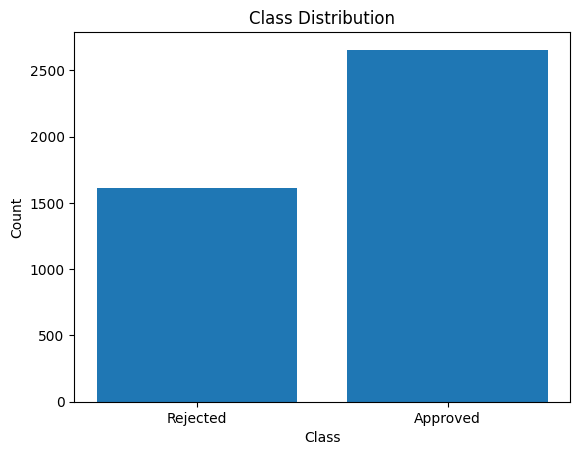

In [6]:
y = df["loan_status"]
x = df.drop(columns=["loan_status"])

plot_counts(y, labels)

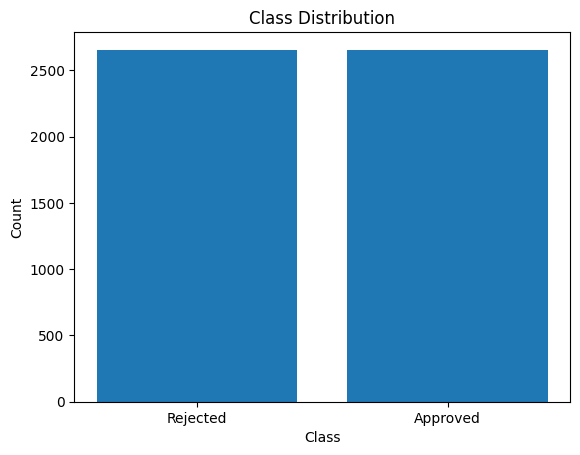

In [7]:
smote = SMOTE(sampling_strategy="minority")
x, y = smote.fit_resample(x, y)

plot_counts(y, labels)

### NefClass

1. Split on train/test/valid

In [8]:
train_ds, valid_ds, test_ds = dataset_split(
    x=x,
    y=y,
    test_train_ratio=0.1,
    valid_train_ratio=0.1,
    random_seed=random_seed,
    batch_size=5000
)

print("Train dataset size: " + str(len(train_ds)) + " batches")
print("Validation dataset size: " + str(len(valid_ds)) + " batches")
print("Test dataset size: " + str(len(test_ds)) + " batches")

Train dataset size: 1 batches
Validation dataset size: 1 batches
Test dataset size: 1 batches


2. Init antecedents

In [9]:
no_of_dependents = Antecedent("no_of_dependents", scale=scale)
no_of_dependents["few"] = ZShapedMfDef(1, 3)
no_of_dependents["many"] = SShapedMfDef(2, 5)

education = Antecedent("education")
education["not_graduated"] = SingletonMfDef(0)
education["graduated"] = SingletonMfDef(1)

self_employed = Antecedent("self_employed")
self_employed["no"] = SingletonMfDef(0)
self_employed["yes"] = SingletonMfDef(1)

income_annum = Antecedent("income_annum", scale=scale)
income_annum["low"] = ZShapedMfDef(20_000_00, 50_000_00)
income_annum["medium"] = GaussMfDef(50_000_00, 20_000_00)
income_annum["high"] = SShapedMfDef(50_000_00, 80_000_00)

loan_amount = Antecedent("loan_amount", scale=scale)
loan_amount["small"] = ZShapedMfDef(10_000_00, 50_000_00)
loan_amount["average"] = GaussMfDef(110_000_00, 60_000_00)
loan_amount["huge"] = SShapedMfDef(170_000_00, 80_000_00)

loan_term = Antecedent("loan_term", scale=scale)
loan_term["short"] = ZShapedMfDef(6, 12)
loan_term["long"] = SShapedMfDef(10, 16)

cibil_score = Antecedent("cibil_score", scale=scale)
cibil_score["poor"] = ZShapedMfDef(500, 580)
cibil_score["fair"] = GaussMfDef(624, 40)
cibil_score["good"] = GaussMfDef(704, 40)
cibil_score["very_good"] = GaussMfDef(770, 25)
cibil_score["excellent"] = SShapedMfDef(800, 820)

residential_assets_value = Antecedent("residential_assets_value", scale=scale)
residential_assets_value["small"] = ZShapedMfDef(50_000_00, 90_000_00)
residential_assets_value["average"] = GaussMfDef(100_000_00, 20_000_00)
residential_assets_value["huge"] = SShapedMfDef(110_000_00, 200_000_00)

commercial_assets_value = Antecedent("commercial_assets_value", scale=scale)
commercial_assets_value["small"] = ZShapedMfDef(50_000_00, 90_000_00)
commercial_assets_value["average"] = GaussMfDef(100_000_00, 20_000_00)
commercial_assets_value["huge"] = SShapedMfDef(120_000_00, 150_000_00)

luxury_assets_value = Antecedent("luxury_assets_value", scale=scale)
luxury_assets_value["cheap"] = ZShapedMfDef(80_000_00, 110_000_00)
luxury_assets_value["average"] = GaussMfDef(150_000_00, 40_000_00)
luxury_assets_value["huge"] = SShapedMfDef(190_000_00, 250_000_00)

bank_asset_value = Antecedent("bank_asset_value", scale=scale)
bank_asset_value["small"] = ZShapedMfDef(40_000_00, 50_000_00)
bank_asset_value["average"] = GaussMfDef(70_000_00, 20_000_00)
bank_asset_value["huge"] = SShapedMfDef(90_000_00, 110_000_00)

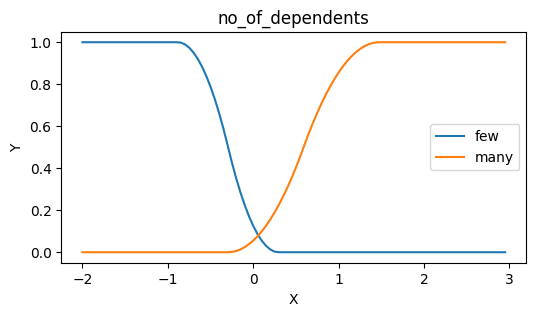

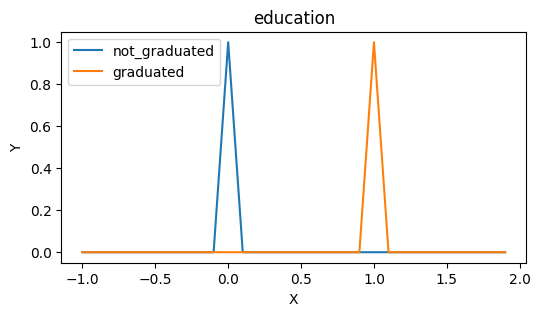

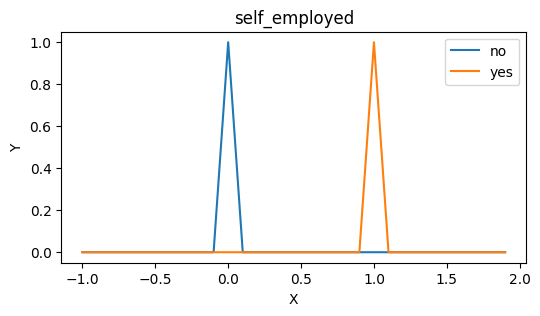

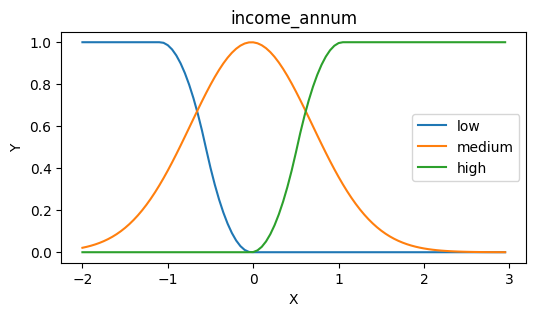

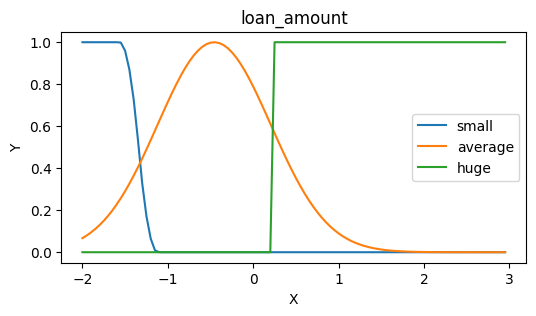

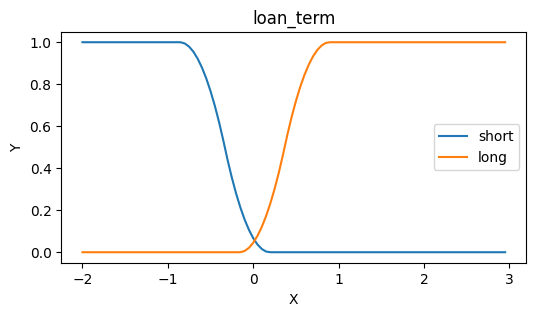

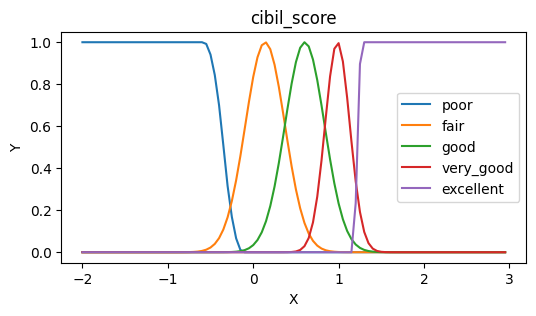

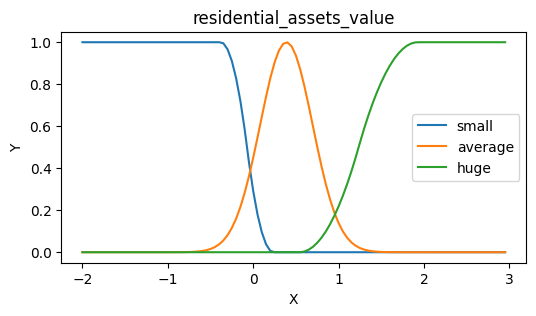

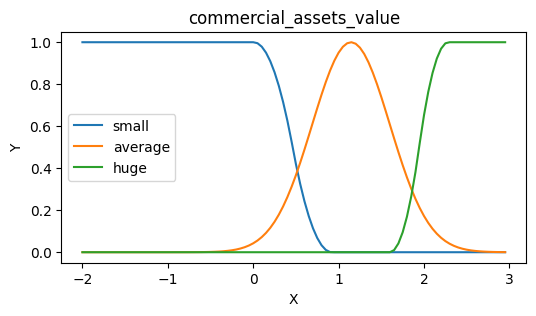

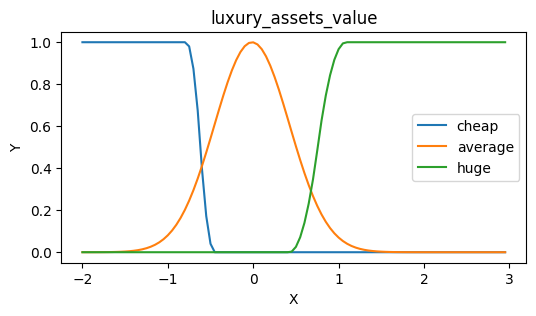

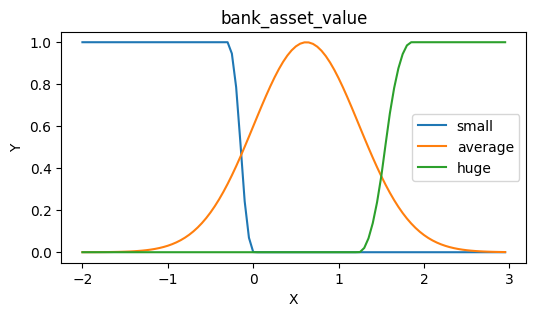

In [10]:
def p_range(start, end, step):
    return torch.arange(start, end, step).to(device)


size = (6, 3)

plot_member_fun(no_of_dependents, p_range(-2, 3, 0.05), size)
plot_member_fun(education, p_range(-1, 2, 0.1), size)
plot_member_fun(self_employed, p_range(-1, 2, 0.1), size)
plot_member_fun(income_annum, p_range(-2, 3, 0.05), size)
plot_member_fun(loan_amount, p_range(-2, 3, 0.05), size)
plot_member_fun(loan_term, p_range(-2, 3, 0.05), size)
plot_member_fun(cibil_score, p_range(-2, 3, 0.05), size)
plot_member_fun(
    residential_assets_value,
    p_range(-2, 3, 0.05),
    size,
)
plot_member_fun(
    commercial_assets_value,
    p_range(-2, 3, 0.05),
    size,
)
plot_member_fun(luxury_assets_value, p_range(-2, 3, 0.05), size)
plot_member_fun(bank_asset_value, p_range(-2, 3, 0.05), size)

3. Prepare model

In [11]:
antecedents = [
    no_of_dependents,
    education,
    self_employed,
    income_annum,
    loan_amount,
    loan_term,
    cibil_score,
    residential_assets_value,
    commercial_assets_value,
    luxury_assets_value,
    bank_asset_value,
]

model = NefClass(antecedents, labels=labels).to(device)

model.eval()

NefClass(
  (_NefClass__input_layer): InputLayer(
    (antecedents): ModuleList(
      (0): Antecedent(
        (_Antecedent__mem_fun): ModuleList(
          (0): ZShapedMf()
          (1): SShapedMf()
        )
      )
      (1-2): 2 x Antecedent(
        (_Antecedent__mem_fun): ModuleList(
          (0-1): 2 x SingletonMf()
        )
      )
      (3-4): 2 x Antecedent(
        (_Antecedent__mem_fun): ModuleList(
          (0): ZShapedMf()
          (1): GaussMf()
          (2): SShapedMf()
        )
      )
      (5): Antecedent(
        (_Antecedent__mem_fun): ModuleList(
          (0): ZShapedMf()
          (1): SShapedMf()
        )
      )
      (6): Antecedent(
        (_Antecedent__mem_fun): ModuleList(
          (0): ZShapedMf()
          (1-3): 3 x GaussMf()
          (4): SShapedMf()
        )
      )
      (7-10): 4 x Antecedent(
        (_Antecedent__mem_fun): ModuleList(
          (0): ZShapedMf()
          (1): GaussMf()
          (2): SShapedMf()
        )
      )
    

4. Learn model rules

In [12]:
rules_trainer = NefClassSimpleRuleTrainer(device)

rules_trainer.train(model, train_ds, max_rules=50)

Create rules:   0%|          | 0/50 [00:00<?, ?it/s]/Users/alexandermelashchenko/Workspace/nefclass/lib/data/panda_ds.py:16: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3701.)
  return self.__x[index].T, self.__y[index]
Create rules: 1275it [00:00, 2163.62it/s]                   


In [13]:
for rule in model.list_rules_str():
    print(rule)

if no_of_dependents is many and education is graduated and self_employed is no and income_annum is low and loan_amount is average and loan_term is long and cibil_score is poor and residential_assets_value is small and commercial_assets_value is small and luxury_assets_value is cheap and bank_asset_value is small then Rejected
if no_of_dependents is few and education is not_graduated and self_employed is yes and income_annum is medium and loan_amount is huge and loan_term is short and cibil_score is poor and residential_assets_value is small and commercial_assets_value is small and luxury_assets_value is average and bank_asset_value is small then Rejected
if no_of_dependents is many and education is graduated and self_employed is yes and income_annum is low and loan_amount is small and loan_term is long and cibil_score is excellent and residential_assets_value is small and commercial_assets_value is small and luxury_assets_value is cheap and bank_asset_value is small then Approved
if no

5. Learn rule parameters

In [14]:
param_trainer = ClassificationTrainer(device)

opt = Adam(model.parameters(), lr=1e-2)
loss = CrossEntropyLoss()

Epoch [100]: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s, accuracy=0.882, loss=0.365, valid_accuracy=0.889, valid_loss=0.355]


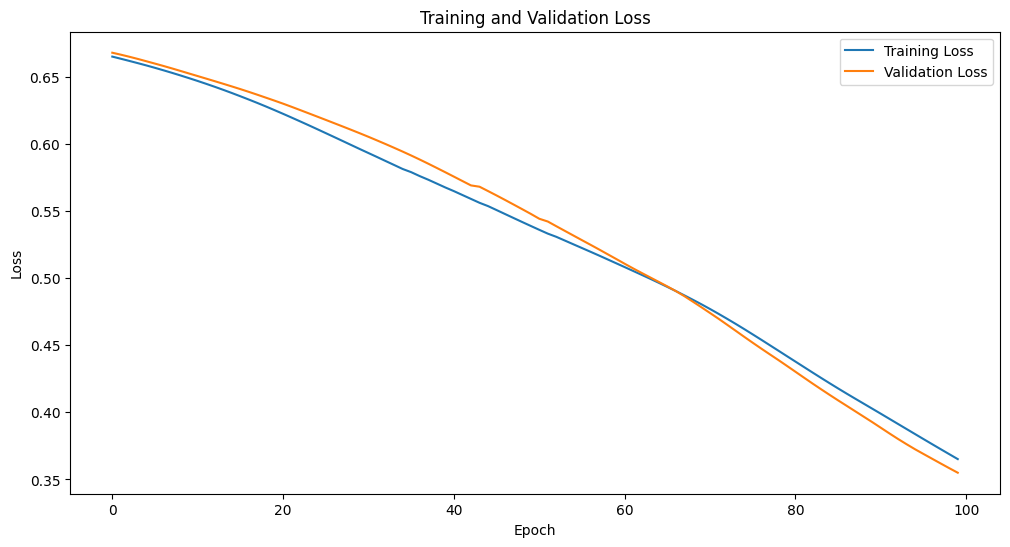

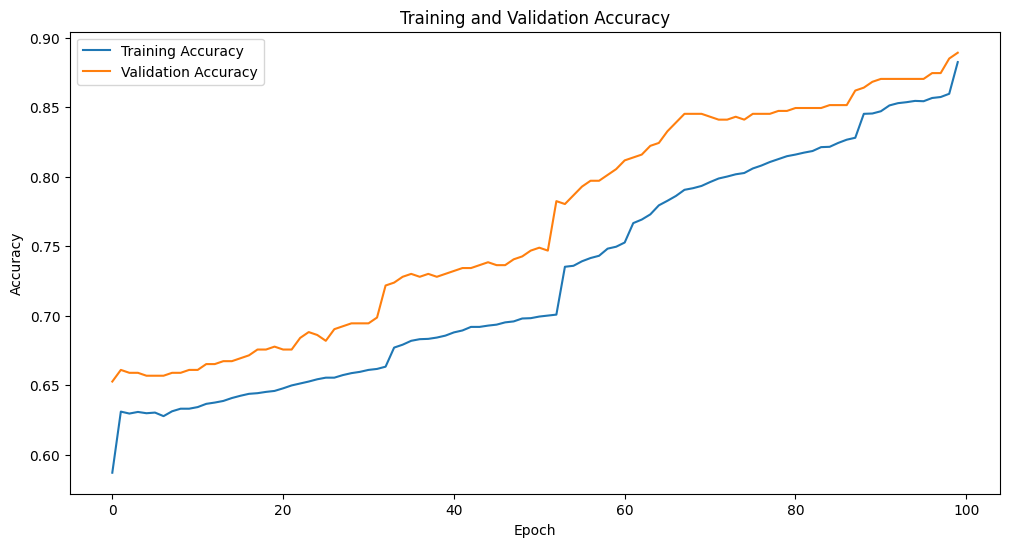

In [15]:
feedback = param_trainer.train(
    model=model,
    num_epochs=100,
    train_loader=train_ds,
    valid_loader=valid_ds,
    loss_fun=loss,
    optimizer=opt,
)

plot_loss_and_val_loss(feedback.train_loss_history, feedback.valid_loss_history)
plot_loss_and_val_accuracy(
    feedback.train_accuracy_history, feedback.valid_accuracy_history
)

6. Test model

Accuracy of the model: 89.84962406015038 %
Loss of the model: 0.3471052646636963


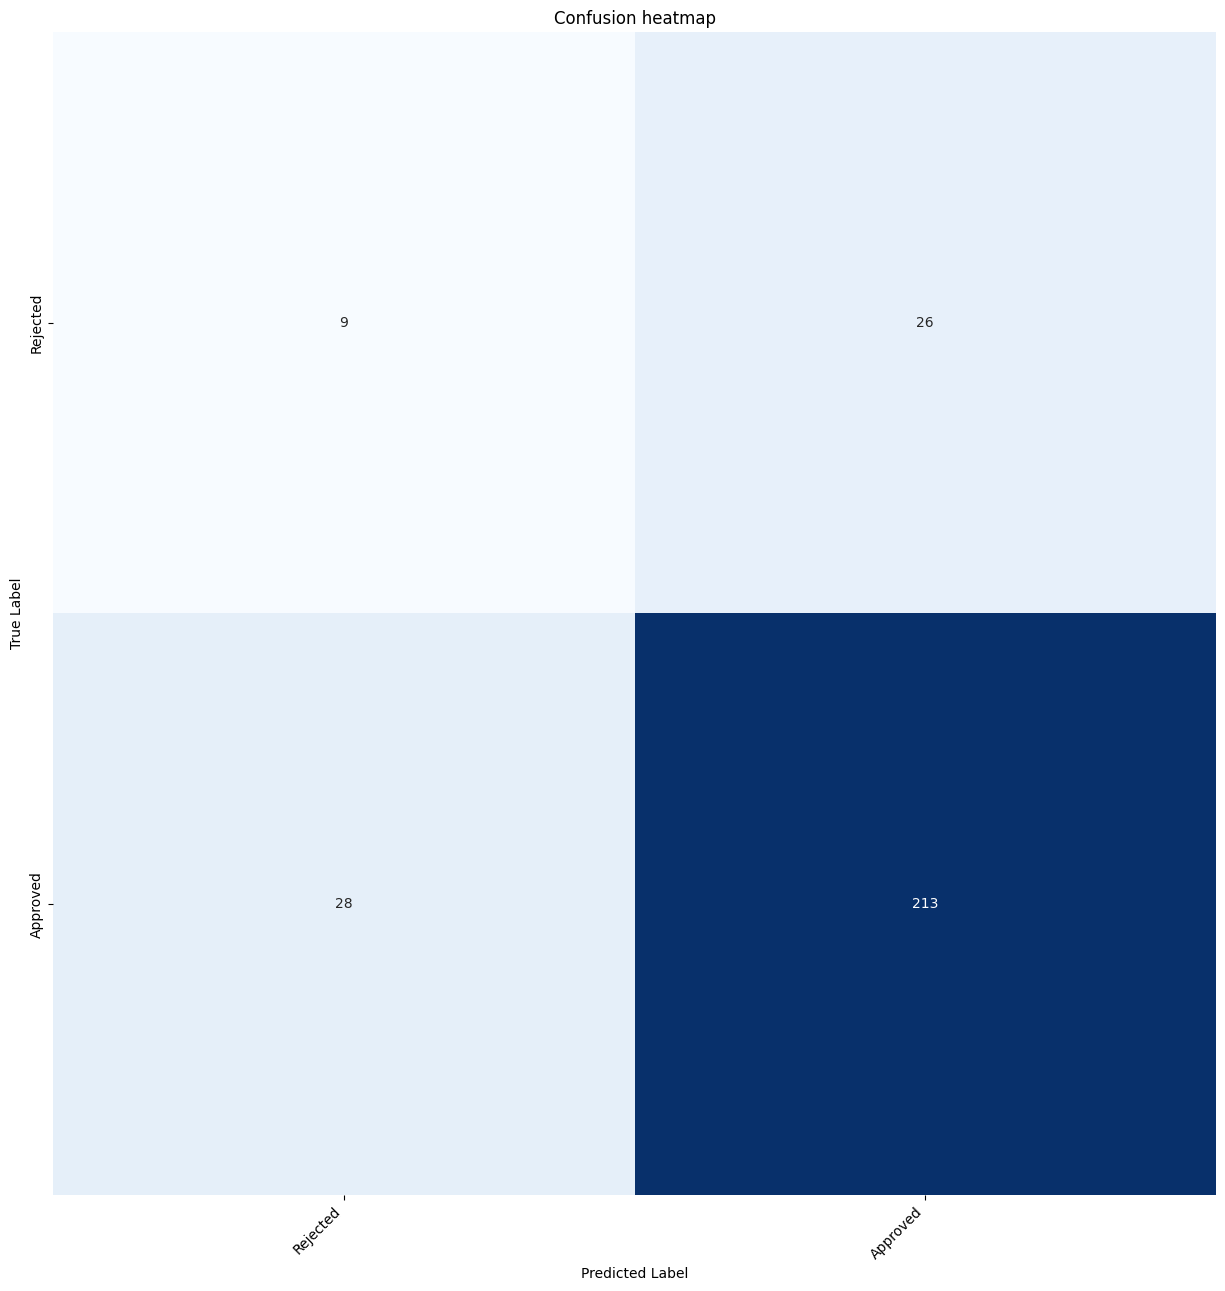

In [16]:
test_loss, test_accuracy, valid_f1, confusion = param_trainer.eval(
    model=model, loss_fun=loss, loader=test_ds, record_class_stats=True
)

print("Accuracy of the model: %s %%" % (test_accuracy * 100))
print("F1 score of the model: %s" % valid_f1)
print("Loss of the model: %s" % test_loss)

plot_confusion_matrix_heatmap(confusion, labels=labels)